# Zadanie nr 1.2.1 - Bazowa implementacja sieci neuronowej MLP
## Metody Inteligencji Obliczeniowej w Analizie Danych
### Paweł Koźmiński, 298825

Poleceniem pierwszego zadania z przedmiotu Metody Inteligencji Obliczeniowej w Analizie Danych było przygotowanie podstawowej implementacji sieci Multi-Layer Perceptor, która będzie podstawą do dalszego rozwijania modelu głębokiego uczenia. Co ważne, przygotowane rozwiązanie powinno umożliwiać użytkownikowi w łatwy sposób zmieniać architekturę sieci - czyli liczbę wejść, wyjść, neuronów w warstwach ukrytych, funkcję aktywacji, wagi połączeń wraz z wartościami obciążeń oraz dane wejściowe. 

W celu przetestowania poprawności implementacji i pierwszego przykładowego użycia, zlecone zostało zadanie regresji na dwóch zbiorach danych: `square-simple` oraz `steps-large`. W treści zadania polecono rozważenie trzech architektur sieci: z 5 neuronami w jednej warstwie ukrytej, z 10 neuronami w jednej warstwie ukrytej, z 5 neuronami w każdej z dwóch ukrytych warstw.

Zaimportowanie potrzebnych funkcji i bibliotek:

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing

Definicja funkcji logistycznej, wykorzystywanej w roli funkcji aktywacji w ukrytych neuronach:

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

W neuronach wyjściowych będzie wykorzystywana funkcja liniowa.

Definicja klasy `Layer` - rdzenia rozwiązania. Konstruktor instancji tej klasy przyjmuje atrybuty:
* `n_inputs` - liczba wejść do warstwy, 
* `neurons` - liczba neuronów w warstwie,
* `weights` - wagi przypisane odpowiednim wejściom do neuronów,
* `bias` - wartości obciążeń,
* `activation` - funkcja aktywacji

In [3]:
class Layer:
    def __init__(self, n_inputs, neurons, weights, bias, activation):
        """
        The constructor of Layer class takes as arguments:
        n_inputs - number of inputs into a layer,
        neurons - number of layers in a layer,
        weights - weights of inputs of a layer - highly recommended for weights to be of class numpy.array,
        bias - values of bias - preferably numpy.array as well,
        activation - activation function (possibly lambda function) 
        """
        self.neurons = neurons
        self.n_inputs = n_inputs
        self.activation = activation
        if len(weights.shape) == 1:
            weights = weights.reshape(1, -1)
        if weights.shape == (n_inputs, neurons):
            self.weights = weights
        else:
            raise AttributeError("The dimensions of weights are not aligned")
        if len(weights.shape) == 1:
            if len(bias) == len(weights):
                self.bias = bias
        elif len(bias) == weights.shape[1]:
            self.bias = bias
        else:
            raise AttributeError("Incorrect length of bias")
    def go(self, x_input):
        """
        x_input - numpy.array containing data used in a layer.
        """
        if x_input.shape[1] != self.n_inputs:
            raise AttributeError("The dimensions of input are incorrect for this layer")
        return self.activation(np.dot(x_input, self.weights) + self.bias)

W konstruktorze klasy `Layer` zostało zaimplementowane sprawdzanie czy wagi wejść oraz obciążeń są odpowiednich wymiarów.

Ponadto dodano implementację metody `go` - przepuszczającej dane przez warstwę z neuronami.

Interfejs zbudowania całej sieci neuronowej, będącej połączeniem warstw, jest funkcja `let_net_go` - przyjmująca jako argumenty poszczególne warstwy w formie listy oraz tablicą numpy z danymi. Funkcja sprawdza czy następujące po sobie warstwy mają ustawione poprawne liczby wejść i wyjść. Ponadto, korzysta ona bezpośrednio z metody `go` klasy `Layer`, wobec czego na bieżąco sprawdzana jest również poprawna wymiarowość danych wejściowych.

In [4]:
def let_net_go(layers_list, input_x):
    for i in range(0, len(layers_list)):
        if i>0 and layers_list[i].n_inputs != layers_list[i-1].neurons:
            raise AttributeError(f"The {i}. layer has {layers_list[i].n_inputs} inputs but {i-1}. layer has {layers_list[i-1].neurons} neurons.")
        input_x = layers_list[i].go(input_x)
    return input_x

# Pierwszy zbiór danych: square-simple

Zbiór danych square-simple zawiera 2 kolumny `x` oraz `y`. Dane w łącznej liczbie rekordów 200 zostały podzielone po połowie na zbiór treningowy i testowy.

In [5]:
train_df = pd.read_csv('../dane/mio1/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../dane/mio1/regression/square-simple-test.csv', index_col=0)
train_df

,x,y
1,-0.171543,-127.351580
2,0.025201,-129.942844
3,-1.368991,38.672367
4,1.907390,197.432191
5,0.011129,-129.988852
...,...,...
96,0.529373,-104.778766
97,1.374914,40.134900
98,-1.101985,-20.706642
99,1.175777,-5.579327


Wartości zmiennej zależnej w danych `square-simple` przyjmują bezwzględnie wysokie wartości w porównaniu ze zmienną niezależną. W celu uruchomienia sieci neuronowych, dane zostaną zestandaryzowane przy pomocy narzędzia `StandardScaler()` z pakietu `sklearn`. 

In [6]:
first_scaler = preprocessing.StandardScaler().fit(train_df)

In [7]:
scaled_train_df = first_scaler.transform(train_df, )
scaled_test_df = first_scaler.transform(test_df,)

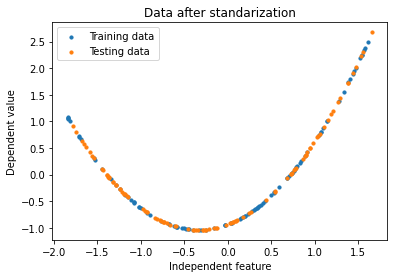

In [8]:
plt.scatter(scaled_train_df[:,0], scaled_train_df[:,1], label = "Training data",s = 10)
plt.scatter(scaled_test_df[:,0], scaled_test_df[:,1], label = 'Testing data', s = 10)
plt.legend()
plt.xlabel("Independent feature")
plt.ylabel("Dependent value")
plt.title("Data after standarization")
plt.show()

W danych ewidentnie można dostrzec zależność kwadratową, niemniej, na wyjściu dopuszczalna jest funkcja liniowa.

## 1 warstwa ukryta, 10 neuronów

Pierwsza ze zbudowanych sieci składa się z jednej warstwy ukrytej zawierającej 10 neuronów. Wartości wag na wejściu były inspirowane efektem pracy `MLPRegressora` z pakietu `sklearn`, wsparte własnymi obserwacjami.

In [9]:
first_layer_10 = Layer(1, 10, np.array([[-0.5, -0.5, -0.03,  0.25, -0.2, -0.3, 0.07, -0.5, 0.1, 0.5]]),
                       np.array([ 0.02, -0.07, -0.3,  0.2, -0.4, 0.2, 0.1, 0.08, 0.3, 0.4]), sigmoid)
second_layer_10 = Layer(10, 1, np.array([[-0.05],[-0.2],[-0.2],[ 0.1],[-0.06],[-0.3],[-0.1],[-0.25],[ 0.35],
                                         [0.1]]), np.array([0.2]), lambda x: x-0.3)

In [10]:
y_pred = let_net_go([first_layer_10, second_layer_10], scaled_train_df[:,0].reshape(-1, 1))

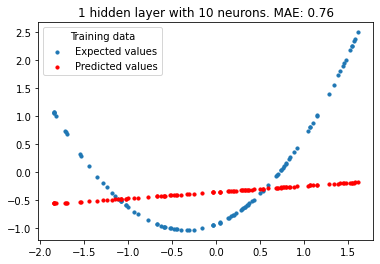

In [11]:
plt.scatter(scaled_train_df[:,0], scaled_train_df[:,1], s = 10, label = "Expected values")
plt.scatter(scaled_train_df[:,0], y_pred.reshape(100,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'1 hidden layer with 10 neurons. MAE: {round(metrics.mean_absolute_error(scaled_train_df[:,1], y_pred), 2)}')
plt.legend(title = "Training data")
plt.show()

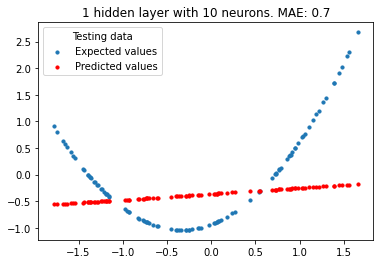

In [12]:
y_test_pred = let_net_go([first_layer_10, second_layer_10], scaled_test_df[:,0].reshape(-1, 1))
plt.scatter(scaled_test_df[:,0], scaled_test_df[:,1], s = 10, label = "Expected values")
plt.scatter(scaled_test_df[:,0], y_test_pred.reshape(100,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'1 hidden layer with 10 neurons. MAE: {round(metrics.mean_absolute_error(scaled_test_df[:,1], y_test_pred), 2)}')
plt.legend(title = "Testing data")
plt.show()

# 1 warstwa ukryta, 5 neuronów

Druga z sieci - 1 warstwa ukryta z 5 neuronami.

In [13]:
first_layer_5 = Layer(1, 5, np.array([[ 0.1, -0.6, -0.5, -0.5, 0.08]]),
                      np.array([0.2, -0.1, -0.3, 0.2, 0.3]), sigmoid)
second_layer_5 = Layer(5, 1, np.array([[ 0.2],[-0.3],[-0.5],[-0.1],[-0.4]]),
                       np.array([0.36782561]), lambda x: x*2-0.2)

In [14]:
y_pred = let_net_go([first_layer_5, second_layer_5], scaled_train_df[:,0].reshape(-1, 1))

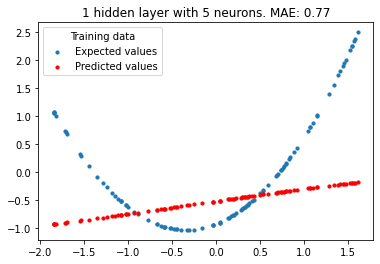

In [15]:
plt.scatter(scaled_train_df[:,0], scaled_train_df[:,1], s = 10, label = "Expected values")
plt.scatter(scaled_train_df[:,0], y_pred.reshape(100,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'1 hidden layer with 5 neurons. MAE: {round(metrics.mean_absolute_error(scaled_train_df[:,1], y_pred), 2)}')
plt.legend(title = "Training data")
plt.show()

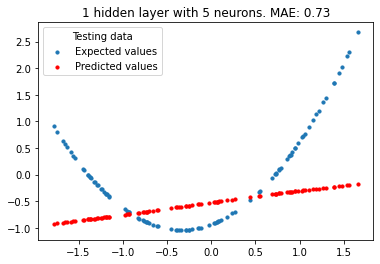

In [16]:
    y_test_pred = let_net_go([first_layer_5, second_layer_5], scaled_test_df[:,0].reshape(-1, 1))
    plt.scatter(scaled_test_df[:,0], scaled_test_df[:,1], s = 10, label = "Expected values")
    plt.scatter(scaled_test_df[:,0], y_test_pred.reshape(100,), s = 10, color = 'red', label = 'Predicted values')
    plt.title(f'1 hidden layer with 5 neurons. MAE: {round(metrics.mean_absolute_error(scaled_test_df[:,1], y_test_pred), 2)}')
    plt.legend(title = "Testing data")
    plt.show()

## 2 warstwy ukryte po 5 neuronów
Trzecia sieć - odrobinę bardziej skomplikowana - składająca się z dwóch ukrytych warstw po 5 neuronów każda.

In [17]:
first_layer_2_5 = Layer(1, 5, np.array([[ 0.1, -0.6, -0.5, -0.5,  0.1]]), np.array([0.2, -0.1, -0.3,  0.2,  0.3]),
                        sigmoid)
second_layer_2_5 = Layer(5, 5, np.array([[ 0.1, -0.5, -0.5, -0.5, 0.1] for i in range(5)]),
        np.array([0.2, -0.1, -0.3, 0.2, 0.3]), sigmoid)
third_layer_2_5 = Layer(5, 1, np.array([[ 0.2],[-0.3],[-0.5],[-0.1],[-0.4]]), np.array([0.4]), lambda x: x-0.5)

In [18]:
y_pred = let_net_go([first_layer_2_5, second_layer_2_5, third_layer_2_5], scaled_train_df[:,0].reshape(-1, 1))

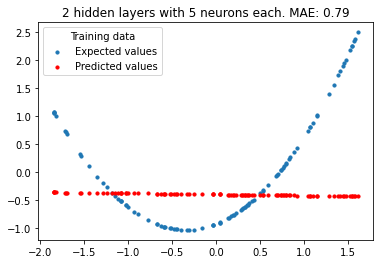

In [19]:
plt.scatter(scaled_train_df[:,0], scaled_train_df[:,1], s = 10, label = "Expected values")
plt.scatter(scaled_train_df[:,0], y_pred.reshape(100,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'2 hidden layers with 5 neurons each. MAE: {round(metrics.mean_absolute_error(scaled_train_df[:,1], y_pred), 2)}')
plt.legend(title = "Training data")
plt.show()

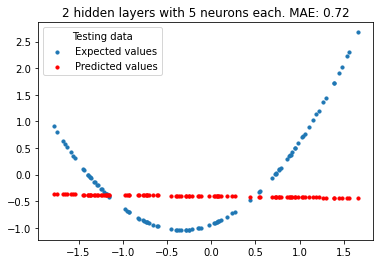

In [20]:
y_test_pred = let_net_go([first_layer_2_5, second_layer_2_5, third_layer_2_5], scaled_test_df[:,0].reshape(-1, 1))
plt.scatter(scaled_test_df[:,0], scaled_test_df[:,1], s = 10, label = "Expected values")
plt.scatter(scaled_test_df[:,0], y_test_pred.reshape(100,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'2 hidden layers with 5 neurons each. MAE: {round(metrics.mean_absolute_error(scaled_test_df[:,1], y_test_pred), 2)}')
plt.legend(title = "Testing data")
plt.show()

Najniższą wartość średniego błędu bezwzględnego osiągnęła pierwsza sieć neuronowa - 0.7.

# Drugi zbiór danych: steps-large

2 kolumny. Dane treningowe: 10000 obserwacji, dane testowe: 1000 obserwacji. Przed procesem budowania sieci, również zostaną zestandaryzowane.

In [21]:
steps_train = pd.read_csv('../dane/mio1/regression/steps-large-training.csv', index_col=0)
steps_test = pd.read_csv('../dane/mio1/regression/steps-large-test.csv', index_col=0)
steps_train

,x,y
1,-1.481354,-80
2,1.033264,80
3,-0.076403,0
4,-1.419785,-80
5,-0.108398,0
...,...,...
9996,1.281784,80
9997,0.460459,0
9998,0.810917,80
9999,0.644318,80


In [22]:
second_scaler = preprocessing.StandardScaler().fit(steps_train)

In [23]:
steps_train_std = second_scaler.transform(steps_train)
steps_test_std = second_scaler.transform(steps_test)


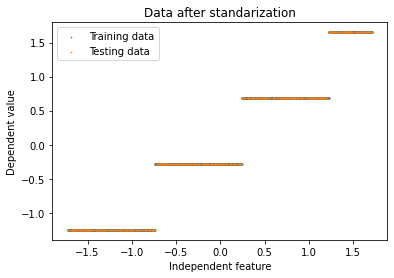

In [24]:
plt.scatter(steps_train_std[:,0], steps_train_std[:,1], label = "Training data",s = 0.4)
plt.scatter(steps_test_std[:,0], steps_test_std[:,1], label = 'Testing data', s = 0.4)
plt.legend()
plt.xlabel("Independent feature")
plt.ylabel("Dependent value")
plt.title("Data after standarization")
plt.show()

Dane wyraźnie można podzielić na 4 grupy przyjmujące tę samą wartość zmiennej celu.

## 1 warstwa ukryta, 10 neuronów


In [25]:
L1 = Layer(1, 10, np.array([[2 for i in range(10)]]), np.array([0 for i in range(10)]), sigmoid)
L2 = Layer(10, 1, np.array([[1] for i in range(10)]), np.array([0]), lambda x: 0.3*(x-0.2)-1.25)

In [26]:
y_pred = let_net_go([L1, L2], steps_train_std[:, 0].reshape(-1, 1))

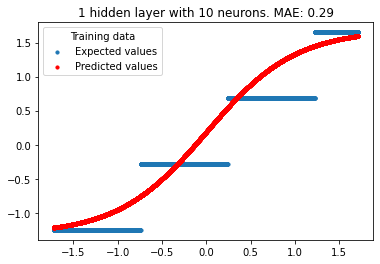

In [27]:
plt.scatter(steps_train_std[:,0], steps_train_std[:,1], s = 10, label = "Expected values")
plt.scatter(steps_train_std[:,0], y_pred.reshape(10000,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'1 hidden layer with 10 neurons. MAE: {round(metrics.mean_absolute_error(steps_train_std[:,1], y_pred), 2)}')
plt.legend(title = "Training data")
plt.show()

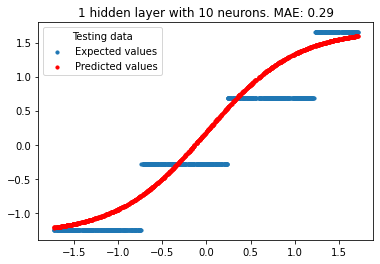

In [28]:
y_test_pred = let_net_go([L1, L2], steps_test_std[:,0].reshape(-1, 1))
plt.scatter(steps_test_std[:,0], steps_test_std[:,1], s = 10, label = "Expected values")
plt.scatter(steps_test_std[:,0], y_test_pred.reshape(1000,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'1 hidden layer with 10 neurons. MAE: {round(metrics.mean_absolute_error(steps_test_std[:,1], y_test_pred), 2)}')
plt.legend(title = "Testing data")
plt.show()

# 1 warstwa ukryta, 5 neuronów

In [29]:
L1_5 = Layer(1, 5, np.array([[1, -1, 1, 3, 4]]), np.array([1 for i in range(5)]), sigmoid)
L2_5 = Layer(5, 1, np.array([[-1], [0],[-2], [3], [8.6]]), np.array([1]), lambda x: 0.3*(x-0.2)-1.25)

In [30]:
y_pred = let_net_go([L1_5, L2_5], steps_train_std[:, 0].reshape(-1, 1))

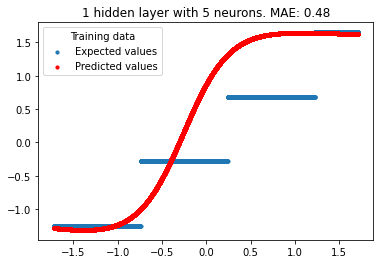

In [31]:
plt.scatter(steps_train_std[:,0], steps_train_std[:,1], s = 10, label = "Expected values")
plt.scatter(steps_train_std[:,0], y_pred.reshape(10000,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'1 hidden layer with 5 neurons. MAE: {round(metrics.mean_absolute_error(steps_train_std[:,1], y_pred), 2)}')
plt.legend(title = "Training data")
plt.show()

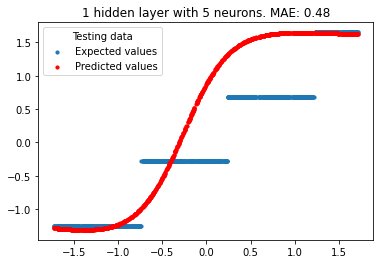

In [32]:
y_test_pred = let_net_go([L1_5, L2_5], steps_test_std[:,0].reshape(-1, 1))
plt.scatter(steps_test_std[:,0], steps_test_std[:,1], s = 10, label = "Expected values")
plt.scatter(steps_test_std[:,0], y_test_pred.reshape(1000,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'1 hidden layer with 5 neurons. MAE: {round(metrics.mean_absolute_error(steps_test_std[:,1], y_test_pred), 2)}')
plt.legend(title = "Testing data")
plt.show()

## 2 warstwy ukryte po 5 neuronów

In [33]:
L1_2_5 = Layer(1, 5, np.array([[1, -1, 1, 3, 4]]), np.array([1 for i in range(5)]), sigmoid)
L2_2_5 = Layer(5, 5, np.array([[1, -1, 1, 3, 4], [1, 3, 1, -1, -8], [-1, 11, -6, 7, 7], [1, 0, 1, -1.5, 0.7], [1, -1, -1.5, 1, 0.5]]), np.array([1 for i in range(5)]), sigmoid)
L3_2_5 = Layer(5, 1, np.array([[-2], [2],[-3], [1], [1]]), np.array([1]), lambda x: x-2.6)

In [34]:
y_pred = let_net_go([L1_2_5, L2_2_5, L3_2_5], steps_train_std[:, 0].reshape(-1, 1))

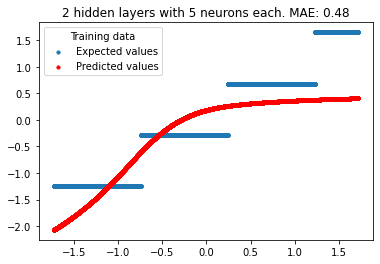

In [35]:
plt.scatter(steps_train_std[:,0], steps_train_std[:,1], s = 10, label = "Expected values")
plt.scatter(steps_train_std[:,0], y_pred.reshape(10000,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'2 hidden layers with 5 neurons each. MAE: {round(metrics.mean_absolute_error(steps_train_std[:,1], y_pred), 2)}')
plt.legend(title = "Training data")
plt.show()

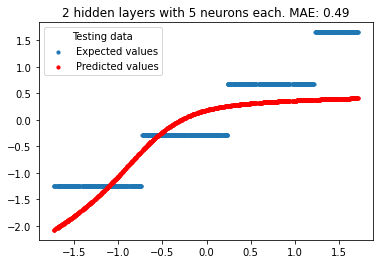

In [36]:
y_test_pred = let_net_go([L1_2_5, L2_2_5, L3_2_5], steps_test_std[:,0].reshape(-1, 1))
plt.scatter(steps_test_std[:,0], steps_test_std[:,1], s = 10, label = "Expected values")
plt.scatter(steps_test_std[:,0], y_test_pred.reshape(1000,), s = 10, color = 'red', label = 'Predicted values')
plt.title(f'2 hidden layers with 5 neurons each. MAE: {round(metrics.mean_absolute_error(steps_test_std[:,1], y_test_pred), 2)}')
plt.legend(title = "Testing data")
plt.show()

W tym przypadku wartości wag były dobierane w pełni samodzielnie. Wartość błędu MAE 0.29 osiągnięta przez pierwszą sieć jest w tym przypadku moim zdaniem niezłym wynikiem.

# Podsumowanie

Ręczne dobieranie wartości wag poszczególnych warstw jest zajęciem żmudnym oraz trudnym - nie da się przewidzieć jak dana określona zmiana wpłynie na skuteczność sieci. Z pewnością też wyniki proponowanych modeli nie są optymalne. Jestem przekonany, że w trakcie kolejnych laboratoriów dowiemy się w jaki sposób przeprowadzić proces uczenia sieci mądrze, co znacznie ułatwi pracę programistyczną w metodach inteligencji obliczeniowej.